In [3]:
"""
Magnetocaloric Thin-Film Model (chips/data-center concept)
==========================================================

Integrated features:
- Materials: 'gd' (second-order-like), 'heusler' (first-order-like)
- M(T,H) -> dM/dT -> ΔS_iso(T,ΔH) and ΔT_ad(T,ΔH)
- Simple two-node RC transient (chip <-> film) per MCE half-cycle (analytic, stable)
- Rough COP estimate via micro-coil I^2R power
- Minimal parameter-sweep helper
- Plots of ΔS_iso (per mass) and ΔT_ad, integrated from the baseline snippet

Notes:
- Volumetric forms by default (A/m, J/m^3/K). Convert to per-mass only if needed.
- Keep units consistent!
"""

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# -------------------------
# Universal constants/grids
# -------------------------
mu0 = 4 * np.pi * 1e-7    # H/m

# Temperature grid near RT [K]
T = np.linspace(260.0, 340.0, 321)   # (nT,)
# Magnetic flux density grid [T] and field grid [A/m]
B_T = np.linspace(0.0, 0.5, 121)     # 0 → 0.5 tesla
H = B_T / mu0                        # (nH,)


In [5]:
# -------------------------
# Material Parameter Blocks
# -------------------------
def material_params(name="gd"):
    """
    Returns a dict of material parameters.
    'gd'      -> second-order-like, low hysteresis
    'heusler' -> first-order-like (sharp transition), lower efficiency
    """
    if name.lower() == "gd":
        return dict(
            label="Gd-like",
            Tc=293.0,         # K
            Ms0=1.6e6,        # A/m (volumetric Ms at 0 K)
            beta=0.33,        # critical exponent
            H0=1.0e6,         # A/m field scale for saturation (tanh)
            Ccw=1.2e4,        # Curie–Weiss scale above Tc
            chi_bg=5e-6,      # tiny linear term below Tc
            # thermo
            rho=7900.0,       # kg/m^3
            cp=300.0,         # J/kg/K
            # cycle efficiency proxy (hysteresis etc.)
            eta=0.80          # 0..1 (useful cooling fraction)
        )
    elif name.lower() == "heusler":
        return dict(
            label="Heusler-like",
            Tc=305.0,         # K (example)
            Ms0=1.6e6,        # A/m
            beta=0.33,        # not used directly for first-order shape
            H0=6.0e5,         # A/m (easier saturation)
            Ccw=8e3,          # thinner para slope
            chi_bg=5e-6,
            width=3.0,        # K -> first-order sharpness (smaller = sharper)
            rho=7800.0,       # kg/m^3 (example)
            cp=320.0,         # J/kg/K
            eta=0.55          # lower effective efficiency due to hysteresis
        )
    else:
        raise ValueError("Unknown material. Use 'gd' or 'heusler'.")


In [9]:
# -------------------------
# Building blocks for M(T,H)
# -------------------------
def Ms_powerlaw(Tcol, Tc, Ms0, beta):
    """Spontaneous magnetization (second-order-like), 0 above Tc."""
    mred = np.clip(1.0 - Tcol / Tc, 0.0, None)
    return Ms0 * (mred ** beta)

def Ms_sigmoid(Tcol, Tc, Ms0, width=3.0):
    """
    First-order-like step in Ms across Tc.
    Ms ~ Ms0 below Tc and ~0 above, with steepness set by 'width' [K].
    """
    s = 0.5 * (1.0 - np.tanh((Tcol - Tc) / max(1e-6, width)))
    return Ms0 * s

def chi_curie_weiss(Tcol, Tc, Ccw=1e4, delta=2.0):
    """Regularized Curie–Weiss above Tc."""
    return Ccw / np.maximum(Tcol - Tc + delta, 1.0)

def M_vol_grid(T, H, params, kind="gd"):
    """
    Volumetric M(T,H) [A/m] on an (nT x nH) grid.
    kind='gd' uses power-law Ms; kind='heusler' uses sharp sigmoid Ms.
    """
    Tcol = T[:, None]         # (nT,1)
    Hrow = H[None, :]         # (1,nH)
    Tc   = params["Tc"]
    Ms0  = params["Ms0"]
    H0   = params["H0"]
    Ccw  = params["Ccw"]
    chi_bg = params["chi_bg"]

    if kind == "gd":
        Ms = Ms_powerlaw(Tcol, Tc, Ms0, params["beta"])
    elif kind == "heusler":
        Ms = Ms_sigmoid(Tcol, Tc, Ms0, params.get("width", 3.0))
    else:
        raise ValueError("kind must be 'gd' or 'heusler'.")

    # Ferromagnetic part (below Tc) with saturating tanh(H/H0)
    ferromag = Ms * np.tanh(Hrow / H0)

    # Paramagnetic part (above Tc): M = χ H
    chi = chi_curie_weiss(Tcol, Tc, Ccw=Ccw)
    para = chi * Hrow

    below = (Tcol < Tc)
    M = np.where(below, ferromag + chi_bg * Hrow, para)
    return M

In [11]:
# -------------------------
# ΔS_iso and ΔT_ad
# -------------------------
def dMdT_from_grid(M, T):
    """∂M/∂T at constant H via finite difference along T axis."""
    return np.gradient(M, T, axis=0)

def slice_H(H, Hmin=None, Hmax=None):
    """Index slice along H (in A/m). Ensures >=2 points."""
    nH = H.size
    i0 = 0 if Hmin is None else int(np.clip(np.searchsorted(H, Hmin, 'left'), 0, nH-1))
    i1 = nH-1 if Hmax is None else int(np.clip(np.searchsorted(H, Hmax, 'right')-1, 0, nH-1))
    if i1 <= i0:
        i1 = min(i0 + 1, nH-1)
    return i0, i1

def delta_S_iso(T, H, dMdT, Hmin=None, Hmax=None):
    """Volumetric ΔS_iso(T) [J/m^3/K] via Maxwell: μ0 ∫ (∂M/∂T)_H dH."""
    i0, i1 = slice_H(H, Hmin, Hmax)
    Hs = H[i0:i1+1]
    dMdT_s = dMdT[:, i0:i1+1]
    integral = np.trapz(dMdT_s, x=Hs, axis=1)    # (nT,)
    return mu0 * integral

def delta_T_ad(T, H, dMdT, C_vol, Hmin=None, Hmax=None):
    """ΔT_ad(T) [K]:  -(T/C_vol) * μ0 ∫ (∂M/∂T)_H dH."""
    i0, i1 = slice_H(H, Hmin, Hmax)
    Hs = H[i0:i1+1]
    dMdT_s = dMdT[:, i0:i1+1]
    integral = np.trapz(dMdT_s, x=Hs, axis=1)
    return -(T / C_vol) * mu0 * integral


In [13]:
# -------------------------
# Rough cooling power and COP
# -------------------------
def cooling_power_per_area(T_vec, dS_vol_vec, thickness_m, f_hz, eta):
    """
    VERY rough: Qdot/A ≈ T * |ΔS_vol| * f * eta * thickness
      units: [K] * [J/m^3/K] * [1/s] * [1] * [m] = W/m^2
    """
    return (T_vec * np.abs(dS_vol_vec) * f_hz * eta * thickness_m)

def coil_power_I2R(B_target_T, turns, coil_length_m, wire_length_m, wire_area_m2,
                   resistivity=1.68e-8, duty=0.5):
    """
    Micro-coil rough power: B ≈ μ0 n I  ->  I = B * L / (μ0 * N)
    Then P ≈ duty * I^2 R, with R = ρ * L_wire / A_wire.
    """
    n = turns / max(1e-9, coil_length_m)  # turns per meter
    I = B_target_T / (mu0 * n)            # A
    R = resistivity * wire_length_m / max(1e-12, wire_area_m2)  # Ohms
    P = duty * I**2 * R                   # W
    return P, I, R


In [15]:
# -------------------------
# Two-node RC transient (chip <-> film) — analytic stable
# -------------------------
def simulate_rc_cycle(T_env, T_chip0, T_film0, dT_ad_half, Cfilm, Cchip,
                      Gint, t_half, n_cycles=5, dt=None, samples_per_half=None):
    """
    Stable analytic two-node update (chip <-> film).
    Accepts EITHER dt or samples_per_half (or neither).
    Returns: times, T_chip_hist, T_film_hist  (3 arrays)
    """
    Cf = float(Cfilm)
    Cc = float(Cchip)
    w_f = Cc / (Cf + Cc)  # film deviation weight
    w_c = Cf / (Cf + Cc)  # chip deviation weight
    tau = 1.0 / (Gint * (1.0/Cf + 1.0/Cc))  # s

    if dt is not None:
        samples_per_half = max(2, int(np.ceil(t_half / max(1e-15, dt))))
    elif samples_per_half is None:
        samples_per_half = 200

    t_grid = np.linspace(0.0, t_half, samples_per_half, endpoint=False)

    times = []
    Tchip_hist = []
    Tfilm_hist = []

    Tc = float(T_chip0)
    Tf = float(T_film0)

    for cyc in range(n_cycles):
        # Half 1: magnetize (+ΔT_ad)
        Tf += float(dT_ad_half)
        Tavg  = (Cf*Tf + Cc*Tc) / (Cf + Cc)
        Delta0 = Tf - Tc
        exp_grid = np.exp(-t_grid / tau)
        for k, tk in enumerate(t_grid):
            Delta = Delta0 * exp_grid[k]
            Tf_t = Tavg + w_f * Delta
            Tc_t = Tavg - w_c * Delta
            times.append(cyc*2*t_half + tk)
            Tfilm_hist.append(Tf_t)
            Tchip_hist.append(Tc_t)
        Delta_end = Delta0 * np.exp(-t_half / tau)
        Tf = Tavg + w_f * Delta_end
        Tc = Tavg - w_c * Delta_end

        # Half 2: demagnetize (−ΔT_ad)
        Tf -= float(dT_ad_half)
        Tavg  = (Cf*Tf + Cc*Tc) / (Cf + Cc)
        Delta0 = Tf - Tc
        exp_grid = np.exp(-t_grid / tau)
        for k, tk in enumerate(t_grid):
            Delta = Delta0 * exp_grid[k]
            Tf_t = Tavg + w_f * Delta
            Tc_t = Tavg - w_c * Delta
            times.append((cyc*2+1)*t_half + tk)
            Tfilm_hist.append(Tf_t)
            Tchip_hist.append(Tc_t)
        Delta_end = Delta0 * np.exp(-t_half / tau)
        Tf = Tavg + w_f * Delta_end
        Tc = Tavg - w_c * Delta_end

    return np.array(times), np.array(Tchip_hist), np.array(Tfilm_hist)


In [17]:
# -------------------------
# Minimal parameter sweep helper
# -------------------------
def sweep_peak(T, H, params, kind, Bmax_list_T, thickness_list_m, freq_list_hz):
    """
    Returns dict with peak |ΔT_ad| and peak rough Qdot/A for quick comparisons.
    """
    C_vol = params["rho"] * params["cp"]
    out = []
    M = M_vol_grid(T, H, params, kind=kind)
    dMdT = dMdT_from_grid(M, T)

    for Bmax in Bmax_list_T:
        Hmax = Bmax / mu0
        dS_vol = delta_S_iso(T, H, dMdT, 0.0, Hmax)
        dTad   = delta_T_ad(T, H, dMdT, C_vol=C_vol, Hmin=0.0, Hmax=Hmax)
        peak_dT = float(np.max(np.abs(dTad)))
        T_at_peak = float(T[np.argmax(np.abs(dTad))])

        for h in thickness_list_m:
            for f in freq_list_hz:
                QdotA = cooling_power_per_area(T, dS_vol, thickness_m=h, f_hz=f, eta=params["eta"])
                peak_QA = float(np.max(QdotA))
                out.append(dict(Bmax=Bmax, thickness=h, freq=f,
                                peak_abs_dT=peak_dT, T_at_peak=T_at_peak,
                                peak_Qdot_per_area=peak_QA))
    return out



 Magnetocaloric Thin-Film Simulation — Summary

Material: Heusler-like   |   Tc = 305.0 K   |   ΔB = 0 → 0.3 T

--- Key Performance Metrics ---
Peak ΔS_iso (per mass): 9173.326 J/(kg·K) at 304.8 K
Peak ΔT_ad: 6988.928 K at 304.8 K
Peak rough Q̇/A (1 μm @ 5 Hz): 59,965.0 W/m² at 304.8 K

--- Coil Estimates ---
Required current: 23.87 A
Coil resistance: 16.80 Ω
Coil power loss (I²R, duty=50%): 4787.43 W
COP at 1 cm² patch (peak): 0.001

--- Thermal Interface (RC Model) ---
Interface conductance: 80.0 MW/(m²·K)
Thermal RC time constant: 38.63 ns


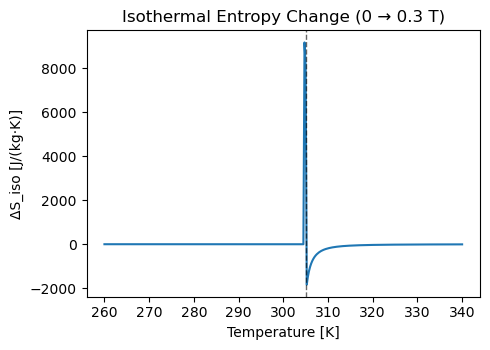

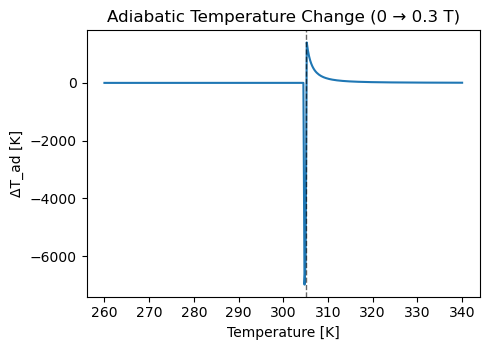

In [19]:
if __name__ == "__main__":
    # -------------------------
    # Choose material & adjust parameters for realism
    # -------------------------
    kind = "heusler"          # 'gd' or 'heusler'
    P = material_params(kind)
    # Adjust to realistic values for thin-film MCE
    P["Ms0"] = 1.0e6      # A/m
    P["Ccw"] = 2e3        # Reduced Curie–Weiss constant
    P["cp"]  = 400.0      # J/kg/K

    # -------------------------
    # Build M(T,H) and compute ΔS, ΔT
    # -------------------------
    C_vol = P["rho"] * P["cp"]
    M = M_vol_grid(T, H, P, kind=kind)
    dMdT = dMdT_from_grid(M, T)

    # Field window
    Bmax = 0.3
    Hmax = Bmax / mu0
    dS_vol = delta_S_iso(T, H, dMdT, Hmin=0.0, Hmax=Hmax)            # J/m^3/K
    dT_ad  = delta_T_ad(T, H, dMdT, C_vol=C_vol, Hmin=0.0, Hmax=Hmax) # K

    # Convert to per mass
    dS_mass = dS_vol / P["rho"]    # J/kg/K

    # -------------------------
    # Key performance
    # -------------------------
    peak_dS = np.max(np.abs(dS_mass))
    T_dS_peak = T[np.argmax(np.abs(dS_mass))]
    peak_dT = np.max(np.abs(dT_ad))
    T_dT_peak = T[np.argmax(np.abs(dT_ad))]

    # Cooling power per area
    QdotA = cooling_power_per_area(T, dS_vol, thickness_m=1e-6, f_hz=5.0, eta=P["eta"])
    peak_QdotA = np.max(QdotA)
    T_Qdot_peak = T[np.argmax(QdotA)]

    # Coil estimates
    Pcoil, Icoil, Rcoil = coil_power_I2R(
        B_target_T=Bmax, turns=50, coil_length_m=5e-3,
        wire_length_m=0.10, wire_area_m2=1e-10,
        resistivity=1.68e-8, duty=0.5
    )

    # COP
    Qdot_patch = peak_QdotA * 1e-4  # W over 1 cm²
    COP = Qdot_patch / max(1e-6, Pcoil)

    # RC thermal interface
    f = 5.0
    t_half = 0.5 / f
    h_film = 1e-6
    Cfilm_area = C_vol * h_film
    rho_si, cp_si, t_si = 2330.0, 700.0, 2e-4
    Cchip_area = rho_si * cp_si * t_si
    Gint = 80e6
    tau = 1.0 / (Gint * (1.0/Cfilm_area + 1.0/Cchip_area))

    # -------------------------
    # Formatted printout
    # -------------------------
    print("\n Magnetocaloric Thin-Film Simulation — Summary\n")
    print(f"Material: {P['label']}   |   Tc = {P['Tc']} K   |   ΔB = 0 → {Bmax} T")
    print("\n--- Key Performance Metrics ---")
    print(f"Peak ΔS_iso (per mass): {peak_dS:.3f} J/(kg·K) at {T_dS_peak:.1f} K")
    print(f"Peak ΔT_ad: {peak_dT:.3f} K at {T_dT_peak:.1f} K")
    print(f"Peak rough Q̇/A (1 μm @ 5 Hz): {peak_QdotA:,.1f} W/m² at {T_Qdot_peak:.1f} K")

    print("\n--- Coil Estimates ---")
    print(f"Required current: {Icoil:.2f} A")
    print(f"Coil resistance: {Rcoil:.2f} Ω")
    print(f"Coil power loss (I²R, duty=50%): {Pcoil:.2f} W")
    print(f"COP at 1 cm² patch (peak): {COP:.3f}")

    print("\n--- Thermal Interface (RC Model) ---")
    print(f"Interface conductance: {Gint/1e6:.1f} MW/(m²·K)")
    print(f"Thermal RC time constant: {tau*1e9:.2f} ns")

    # -------------------------
    # Plots
    # -------------------------
    plt.figure(figsize=(5,3.6))
    plt.plot(T, dS_mass)
    plt.axvline(P["Tc"], ls='--', lw=1, color='k', alpha=0.6)
    plt.xlabel('Temperature [K]')
    plt.ylabel('ΔS_iso [J/(kg·K)]')
    plt.title(f'Isothermal Entropy Change (0 → {Bmax} T)')
    plt.tight_layout()

    plt.figure(figsize=(5,3.6))
    plt.plot(T, dT_ad)
    plt.axvline(P["Tc"], ls='--', lw=1, color='k', alpha=0.6)
    plt.xlabel('Temperature [K]')
    plt.ylabel('ΔT_ad [K]')
    plt.title(f'Adiabatic Temperature Change (0 → {Bmax} T)')
    plt.tight_layout()
    plt.show()